# Introducción

El propósito de este notebook es crear un modelo de inteligencia artificial capaz de reconocer jugadas de piedra, papel o tijera a partir de gestos con la mano. Aunque el impacto directo de este modelo en el mundo puede no ser significativo, presenta casos de uso interesantes que justifican su creación.

En primer lugar, el modelo puede ser lo suficientemente preciso en el reconocimiento de gestos de manos como para servir como base en la creación de otros modelos que detecten gestos con las manos.

Además, podría ser utilizado como parte integral de un proyecto más grande, como un robot que juegue piedra, papel o tijera, lo cual tiene más relevancia como prueba de lo que es posible.

El dataset utilizado puede ser encontrado en: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset?select=Rock-Paper-Scissors

#En caso de estar en google colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/DeepLearning/RockPaperScissors/Rock-Paper-Scissors

Mounted at /content/gdrive
/content/gdrive/MyDrive/DeepLearning/RockPaperScissors/Rock-Paper-Scissors


#Datos

El dataset que se utiliza en este notebook consiste de 2925 imagenes de 300 x 300 pixeles, todas a color que muestran gente de diferentes razas y generos haciendo los gestos del juego con sus manos, de las cuales ya vienen divididas en subcarpetas de entrenamiento, prueba y validación.

Hay 840 imagenes de entrenamiento, 124 de prueba y 11 de validación por cada clase (Piedra, Papel o Tijerra).



#Desarrollo

In [2]:
#Importar algunas librerias que se usaran en los proximos bloques.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Lo primero que se realizo es usar el ImageDataGenerator de keras para crear mas imagenes a partir del dataset usando Augmentation. Esto se realizo con el objetivo de ayudar al modelo a generalizar al momento de entrenarlo, esto lo hice tambien porque al revisar el dataset me parecio que las imagenes tienden a seguir un orden implicito, todas son imagenes tomadas desde la perspectiva de la persona y ademas todas las imagenes son de la mano derecha.

In [3]:

#Creamos nuestro objeto para realizar la Augmentation en el dataset de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizamos los datos para que sean mas faciles de entender para el modelo.
    shear_range=0.2, # Le aplicamos un transformación de shear, la cual cambiara un poco la perspectiva de la imagen.
    zoom_range=0.2, # Una transformación de zoom, la cual acercara la imagen.
    horizontal_flip=True #Y le habilitamos un flip en el eje horizontal para que el modelo aprenda que las manos pueden tener otras orientaciones.
)

#Creamos nuestro objeto para realizar la augmentacion en el dataset de Testing
test_datagen = ImageDataGenerator(rescale=1./255)

#Se especifica el directorio de donde tiene que sacar las imagenes y empieza a hacer el augementation.
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/DeepLearning/RockPaperScissors/Rock-Paper-Scissors/train', #Directorio de las imagenes.
    target_size=(300, 300), #Tamaño de las imagenes
    batch_size=32,    #Numero de imagenes por batch
    class_mode='categorical' #Especificamos que nuestros datos son categoricos.
)

validation_generator = test_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/DeepLearning/RockPaperScissors/Rock-Paper-Scissors/validation',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)


Found 2520 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


Ahora crearemos la estructura del modelo. Aqui el objetivo es crear una Convolutional Neural Network (CNN) para hacer que al modelo se le facilite identificar los rasgos de los gestos. En esta parte hubo mucho ajuste de la arquitectura y de los hyperparametros, se probaron hacer cambios en arquitectura, al agregar o quitar capas de convoluciones, cambiar el numero de filtros por capa, el tamaño de los kernels, el tamaño de las capas densas del final y el numero de estas mismas. Por el momento esta estructura brindo los mejores resultados, los cuales nos son los mejores pero diria que es un buen avance.

In [27]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(300, 300, 3), activation='relu')) #Primero defino una capa convolucional con 16 filtros y un kernel de 3x3, esta capa tambien actua como la input layer
model.add(MaxPooling2D(pool_size=(2, 2))) #Una capa para hacerle pooling a la imagen, efectivamente reduciendo el tamaño a la mitad
model.add(Conv2D(32, (3, 3), activation='relu')) #Otra capa convolucional, esta vez de 32 filtros.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))# De aqui en adelante las capas convolucionales tienen 64 filtros.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) #Le hacemos flatten a los inputs restantes, para poder cargarlos con facilidad a la siguiente capa densa.
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax')) # Esta capa densa nos regresa la imagen a la que segun la red tiene mas posibilidad de pertenecer la imagen.

model.summary() #Imprimimos un resumen del modelo.



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 149, 149, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 35, 35, 64)       

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Se hace fit a el modelo con 25 epochs.

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/30
79/79 [==============================] - 76s 888ms/step - loss: 1.0186 - accuracy: 0.4679 - val_loss: 0.9507 - val_accuracy: 0.6364
Epoch 2/30
79/79 [==============================] - 68s 863ms/step - loss: 0.4983 - accuracy: 0.8004 - val_loss: 0.5054 - val_accuracy: 0.7273
Epoch 3/30
79/79 [==============================] - 73s 924ms/step - loss: 0.1231 - accuracy: 0.9631 - val_loss: 0.3565 - val_accuracy: 0.9091
Epoch 4/30
79/79 [==============================] - 80s 1s/step - loss: 0.1504 - accuracy: 0.9643 - val_loss: 0.2834 - val_accuracy: 0.9394
Epoch 5/30
79/79 [==============================] - 81s 1s/step - loss: 0.0340 - accuracy: 0.9869 - val_loss: 0.4384 - val_accuracy: 0.9091
Epoch 6/30
79/79 [==============================] - 87s 1s/step - loss: 0.0830 - accuracy: 0.9817 - val_loss: 0.1935 - val_accuracy: 0.8788
Epoch 7/30
79/79 [==============================] - 69s 872ms/step - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.3350 - val_accuracy: 0.9697
Epoch 8/

In [22]:
#Cargamos nuestros datos de prueba para hacer prediciones y hacemos una pequeña prueba.
test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/DeepLearning/RockPaperScissors/Rock-Paper-Scissors/test',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test loss: {loss:.4f}, test accuracy: {accuracy:.4f}')

Found 372 images belonging to 3 classes.
12/12 [==============================] - 3s 267ms/step - loss: 0.9413 - accuracy: 0.9301
Test loss: 0.9413, test accuracy: 0.9301


#Resultados

Para evaluar el modelo decidi someterlo y graficar varias diferentes estadisticas, primero simplemente voy a imprimir unas imagenes tomadas al azar del conjunto de prueba para ver como le va. En general como se puede ver al correr este codigo, el modelo demuestra acertar casi siempre, pero esto no es tan buen indicador de su eficiencia entonces hacemos otras pruebas.

1/1 [==============================] - 0s 40ms/step


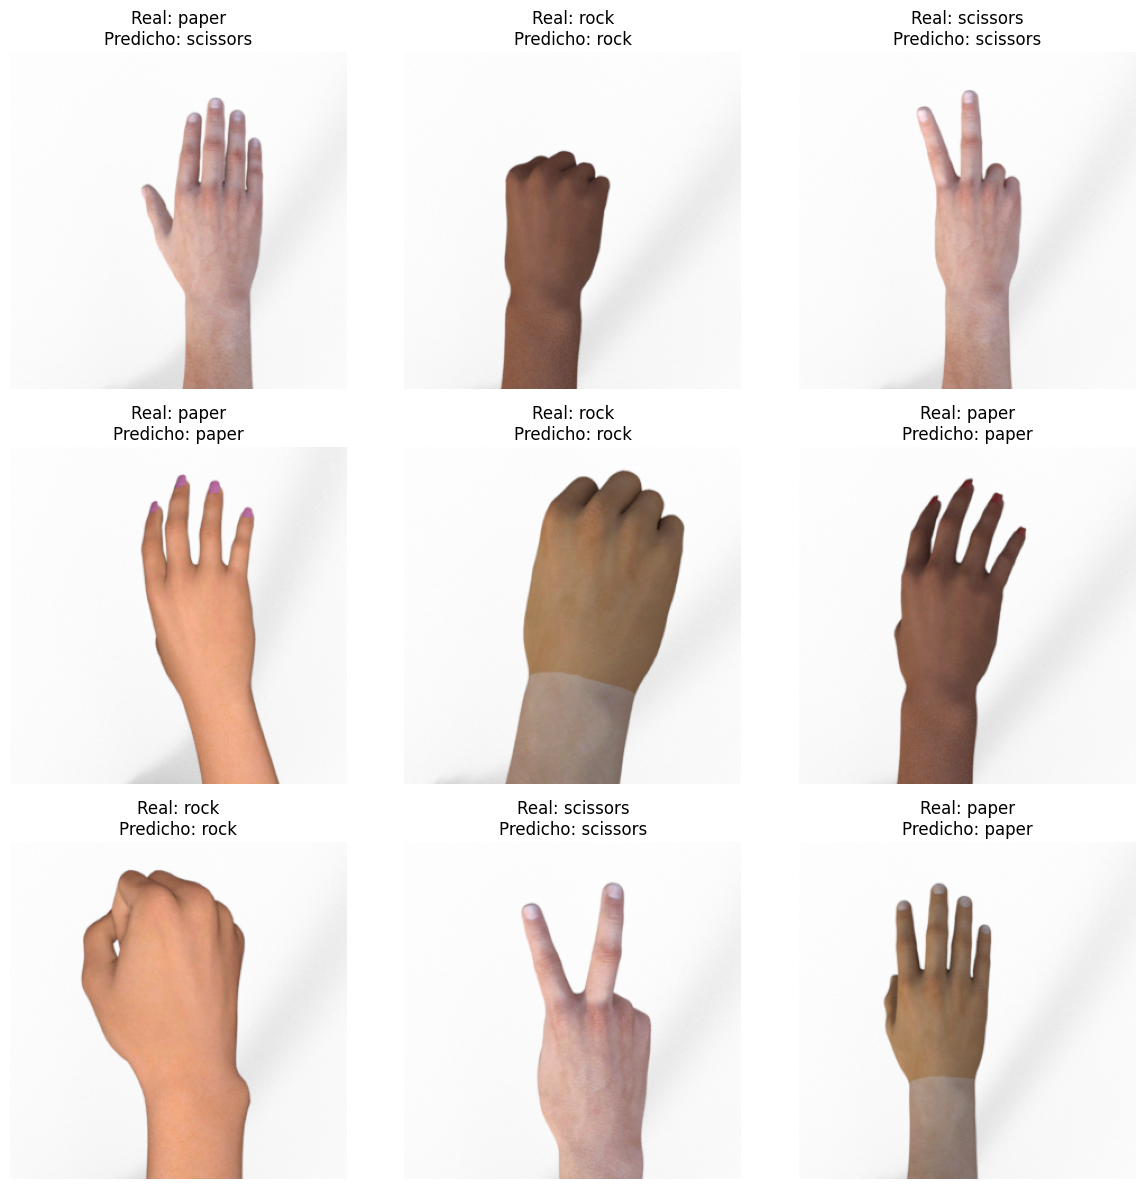

In [30]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image
import numpy as np


# Sacamos las imagenes de la variable que se definio anteriormente
class_labels = list(test_generator.class_indices.keys())


# Sacamos 9 imagenes al azar
random_images = random.sample(test_generator.filenames, 9)

#Graficamos una las imagenes con sus valores reales y los predichos por el modelo.
plt.figure(figsize=(12, 12))
for i, image_path in enumerate(random_images):
    img_path = '/content/gdrive/MyDrive/DeepLearning/RockPaperScissors/Rock-Paper-Scissors/test/' + image_path

    img = image.load_img(img_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_label = class_labels[np.argmax(prediction)]
    true_label = class_labels[test_generator.classes[test_generator.filenames.index(image_path)]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Real: {true_label}\nPredicho: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Hacemos un calculo de una matriz de confusion usando la libreria de sklearn, esto con el fin de darnos una alternativa para poder interpretar el desempeño del modelo. En general no se ve muy bien, de hecho parece tener un bias con papel.

12/12 [==============================] - 3s 218ms/step
[[39 45 40]
 [42 38 44]
 [33 48 43]]


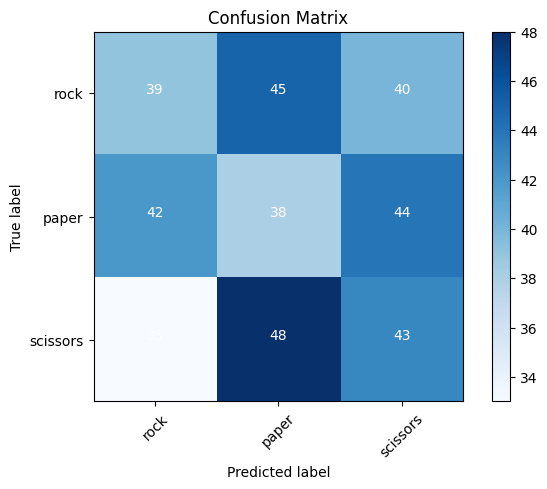

In [31]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

#Sacamos los valores reales y los predichos
true_labels = test_generator.classes
num_batches = len(test_generator)
predictions = model.predict(test_generator, steps=num_batches)
predicted_labels = np.argmax(predictions, axis=1)

#Calculamos la matriz
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['rock', 'paper', 'scissors']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()

Como ultimas pruebas vamos a graficar el loss y la exactitud del modelo para poder, en general lo que llego a interpretar de estos resultados es que el modelo tiene un overfit y por eso la loss y la exactitud del modelo se mueven de manera tan extraña en las graficas.

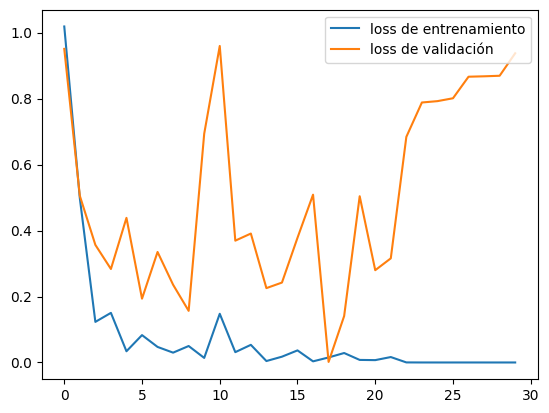

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss de entrenamiento')
plt.plot(history.history['val_loss'], label='loss de validación')
plt.legend()
plt.show()

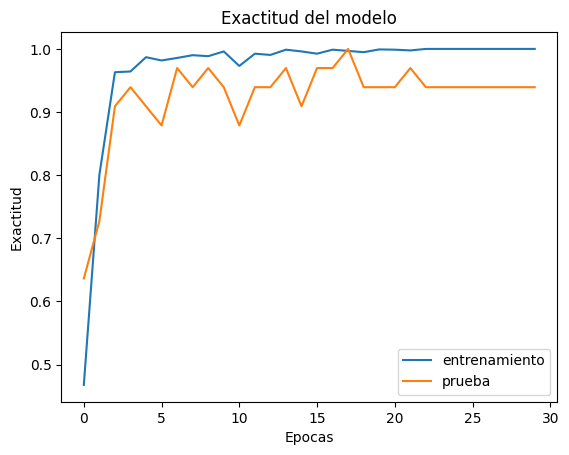

In [33]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()

#Conclusiones

En general creo que el desarrollo del modelo no estuvo mal, pero definitivamente tiene areas de mejora. Me gustaria probar un transfer learning en un proximo intento, me parece que con el modelo (preentrenado) adecuado los resultados serian mucho mejores. Tambien creo que seria util usar batch normalization y algunos dropouts con esta arquitectura actual para talvez mejorarlo sin tener que usar un modelo preentrenado.